> Feature Importance for the Better-Performing Model

In [1]:
# Import statements
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import pickle
from sklearn.pipeline import Pipeline
import os

In [2]:
# Load the cleaned data
data = pd.read_csv('../data/processed/data_abnormal_values_treated.csv') 
data.head()

,Unnamed: 0,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,0,40.0,M,ATA,140.0,289.0,0,Normal,172.0,N,0.0,Up,0
1,1,49.0,F,NAP,160.0,180.0,0,Normal,156.0,N,1.0,Flat,1
2,2,37.0,M,ATA,130.0,283.0,0,ST,98.0,N,0.0,Up,0
3,3,48.0,F,ASY,138.0,214.0,0,Normal,108.0,Y,1.5,Flat,1
4,4,54.0,M,NAP,150.0,195.0,0,Normal,122.0,N,0.0,Up,0


In [3]:
# Seperate X and y dataframes
feature_columns = data.columns[1 :-1]

X = data[feature_columns]
y = data['HeartDisease'] 

In [4]:
# Train/test splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # dataset
    train_size = 0.8, # the size of training set = 80%
    shuffle = True, #to avoid ordering effect
    stratify = y, # maintain the distribution of y classes in both training and test sets
    random_state = 42
)

In [5]:
# Load the saved pipeline
with open('../models/Random_Forest_best_model.pkl', 'rb') as file:
    Pipeline_final = pickle.load(file)

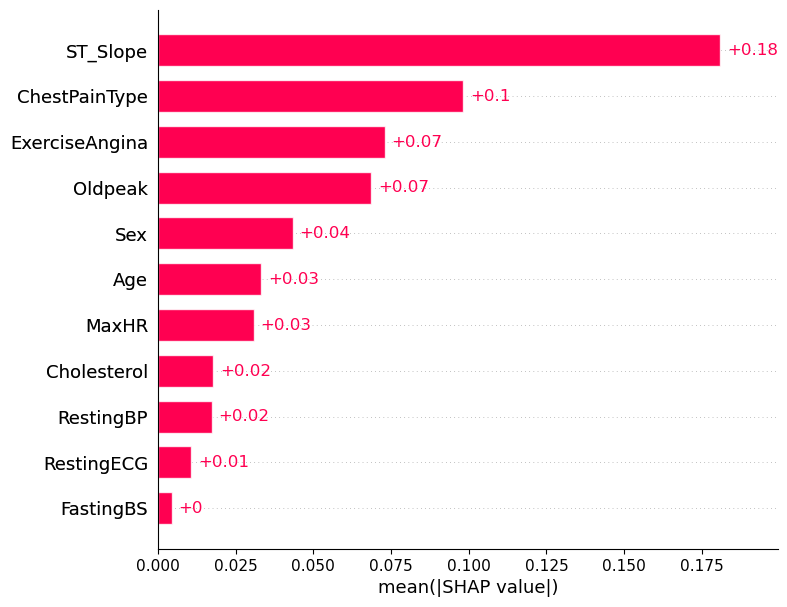

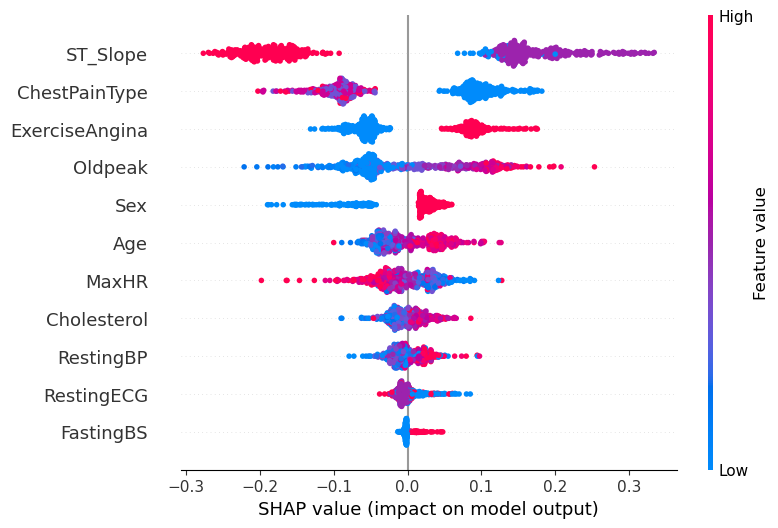


Waterfall Plot for Observation 12


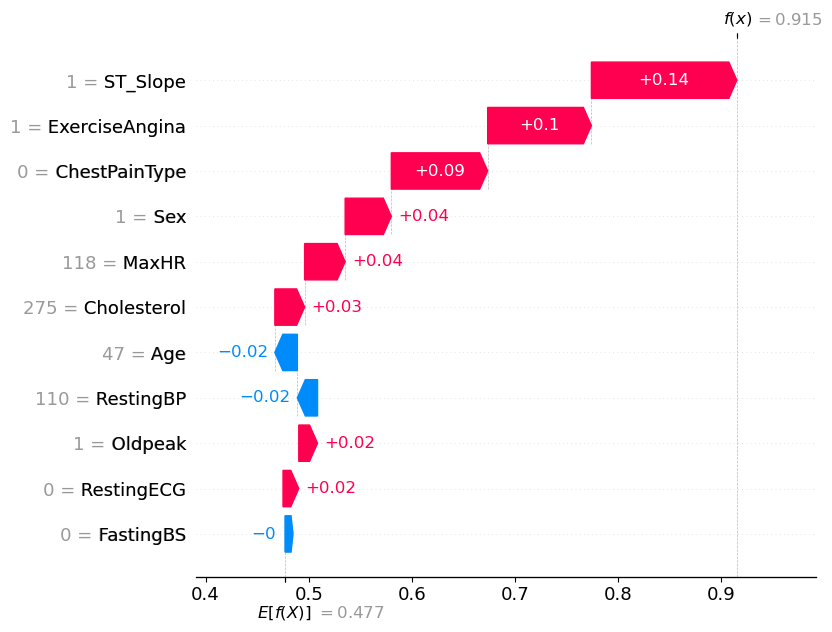


Force Plot for Observation 12


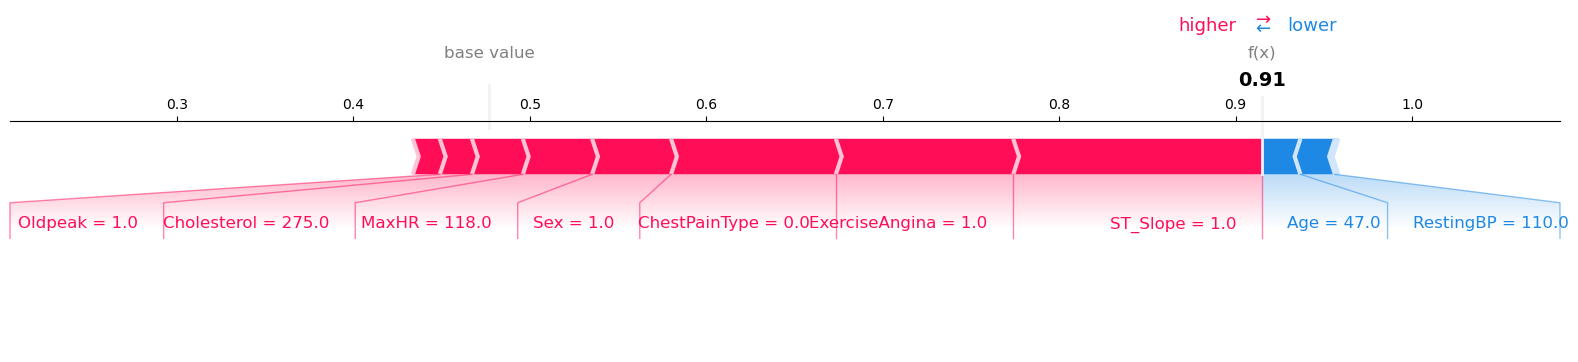


Waterfall Plot for Observation 36


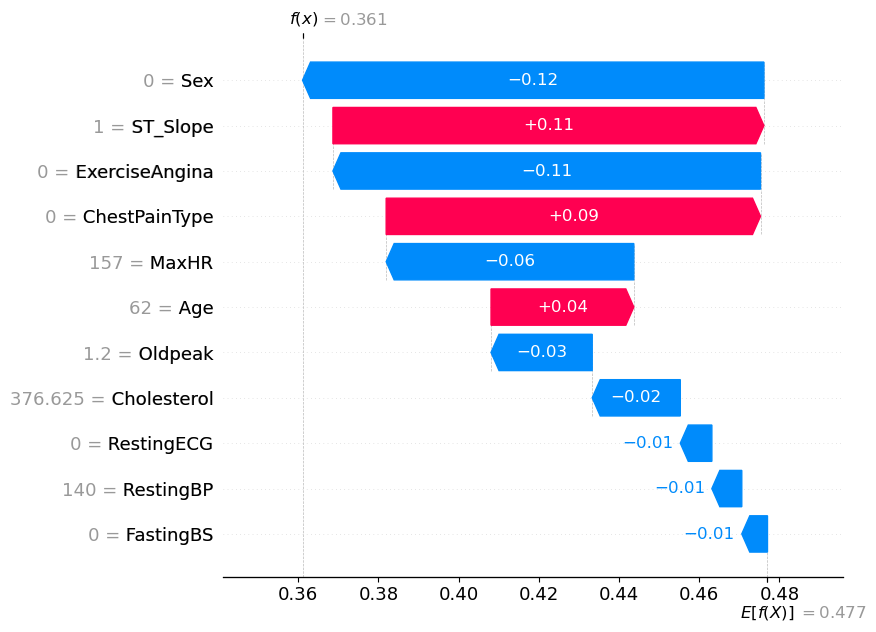


Force Plot for Observation 36


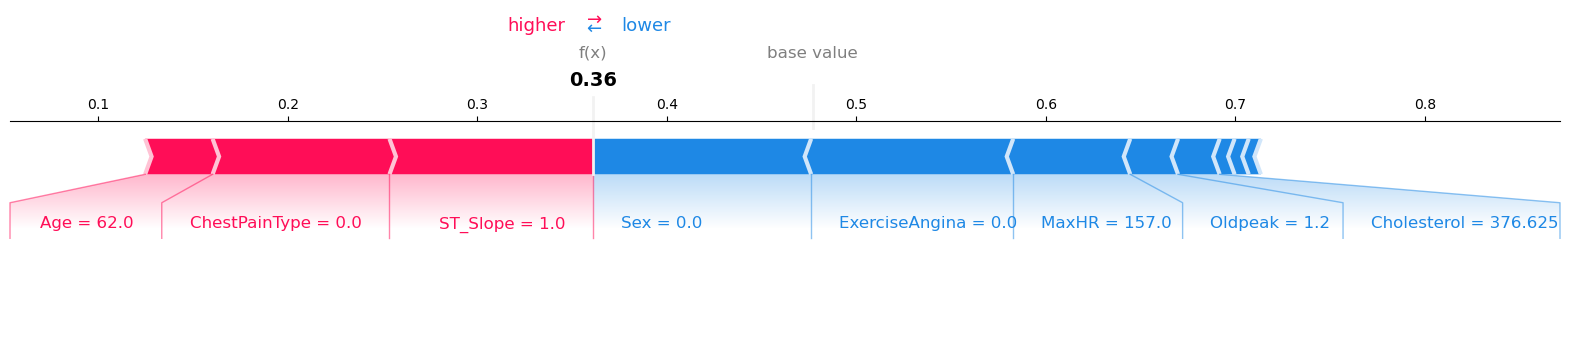

In [6]:
# Ensure all features are displayed in pandas outputs
pd.set_option('display.max_columns', None)

# Get preprocessing and classifier from the pipeline
preprocessor = Pipeline_final.named_steps['Feature Engineering']
classifier = Pipeline_final.named_steps['classifier']

# Transform the training and test data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Get feature names from the preprocessor
original_feature_names = preprocessor.get_feature_names_out()

# Convert to original feature names
rename_map = {
    'LabelEncoding__ST_Slope': 'ST_Slope',
    'LabelEncoding__ChestPainType': 'ChestPainType',
    'LabelEncoding__ExerciseAngina': 'ExerciseAngina',
    'remainder__Oldpeak': 'Oldpeak',
    'remainder__MaxHR': 'MaxHR',
    'LabelEncoding__Sex': 'Sex',
    'LabelEncoding__FastingBS': 'FastingBS',
    'remainder__Cholesterol': 'Cholesterol',
    'remainder__Age': 'Age',
    'remainder__RestingBP': 'RestingBP',
    'LabelEncoding__RestingECG': 'RestingECG'
}
simplified_feature_names = [rename_map.get(name, name) for name in original_feature_names]

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(classifier, feature_names=simplified_feature_names)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_transformed)

# Compute SHAP values for the training set (global explanation)
shap_values_global = explainer(X_train_transformed)

# Bar plot of mean absolute SHAP values
shap.plots.bar(shap_values_global[:, :, 1].abs.mean(0), max_display=len(simplified_feature_names))

# Beeswarm plot
shap.plots.beeswarm(shap_values_global[:, :, 1], max_display=len(simplified_feature_names))

# Waterfall and Force plots for two selected observations
    # One with heart disease (obs 12) and the other without heart disease (obs 36).
    # Only the one with heart disease (obs 12) will be shown in PROJECT README.
for i in [12, 36]:
    shap_single = shap_values_global[i, :, 1]

    explanation = shap.Explanation(
        values=shap_single,
        base_values=explainer.expected_value[1],
        data=X_test_transformed[i],
        feature_names=simplified_feature_names
    )

    print(f"\nWaterfall Plot for Observation {i}")
    shap.plots.waterfall(explanation, max_display=len(simplified_feature_names))

    print(f"\nForce Plot for Observation {i}")
    shap.plots.force(explanation, matplotlib=True)